In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#loading data
Non_MI_data = np.load('Non_MI_data.npy')
Non_MI_label = np.load('Non_MI_label.npy')
MI_data = np.load('MI_data.npy')
MI_label = np.load('MI_label.npy')

In [3]:
#calculate average of Non-MI
average_Non_MI = []
for j in range(len(Non_MI_data[0])):
    sum_value =0
    for i in range(len(Non_MI_data)):
        sum_value += Non_MI_data[i][j]
    average_value = sum_value / len(Non_MI_data)
    average_Non_MI.append(average_value)

In [4]:
#calculate average of MI
average_MI = []
for j in range(len(MI_data[0])):
    sum_value =0
    for i in range(len(MI_data)):
        sum_value += MI_data[i][j]
    average_value = sum_value / len(MI_data)
    average_MI.append(average_value)

In [8]:
#model struture reloading
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc  = nn.Sequential(        
            nn.Linear(382, 382//2),      
            nn.ReLU(True),
            nn.Linear(382//2,382//4),
            nn.ReLU(True),
            nn.Linear(382//4,382//8),
        )
        self.out = nn.Linear(382//8, 2) 

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), -1)           
        output = self.out(x)
        return output, x

In [31]:
#parameters
EPOCH = 200
BATCH_SIZE = 50
TIME_STEP = 1
INPUT_SIZE = 382
LR = 0.001

#replace each variables with average and feed into fully trained model to calculate the sensitivity changes 
sensitivity10 = []
for num in range(5):
    sen = []
    Non_MI_data = np.load('Non_MI_data.npy')
    Non_MI_label = np.load('Non_MI_label.npy')
    MI_data = np.load('MI_data.npy')
    MI_label = np.load('MI_label.npy')

#calculate Non-MI average    
    average_Non_MI = []
    for j in range(len(Non_MI_data[0])):
        sum_value =0
        for i in range(len(Non_MI_data)):
            sum_value += Non_MI_data[i][j]
        
        average_value = sum_value / len(Non_MI_data)
        average_Non_MI.append(average_value)

#calculate MI changes
    average_MI = []
    for j in range(len(MI_data[0])):
        sum_value =0
        for i in range(len(MI_data)):
            sum_value += MI_data[i][j]
        average_value = sum_value / len(MI_data)
        average_MI.append(average_value)

#loading model    
    rnn = torch.load('dnnL_best_{}'.format(num)+'.pkl')
    
    sensitivity_Non_MI = []
    Non_MI_data = torch.from_numpy(Non_MI_data)
    Non_MI_data = torch.tensor(Non_MI_data, dtype=torch.float32)
    Non_MI_data_re_standard = Non_MI_data.reshape(Non_MI_data.shape[0], TIME_STEP, INPUT_SIZE)
    
    Non_MI_data_out,last_layer = rnn(Non_MI_data_re_standard)
    pred_Non_MI_standard = torch.max(Non_MI_data_out, 1)[0].data.squeeze().numpy().tolist()

#calculate the Non-MI changes     
    for i in range(len(average_Non_MI)):
        Non_MI_data = np.load('Non_MI_data.npy')
        Non_MI_data = torch.from_numpy(Non_MI_data)
        Non_MI_data = torch.tensor(Non_MI_data, dtype=torch.float32)
        
        for j in range(len(Non_MI_data)):
            Non_MI_data[j][i] = average_MI[i]    
        Non_MI_data_re = Non_MI_data.reshape(Non_MI_data.shape[0], TIME_STEP, INPUT_SIZE)
        Non_MI_data_out,last_layer = rnn(Non_MI_data_re)
        pred_Non_MI = torch.max(Non_MI_data_out, 1)[0].data.squeeze().numpy().tolist()
        divd_val = []
        for b in range(len(pred_Non_MI)):
            val = pred_Non_MI[b] - pred_Non_MI_standard[b]
            divd_val.append(val)
        sum_val = 0
        
        for a in divd_val:
            sum_val += a
        sensitivity_Non_MI.append(sum_val)
    
    sensitivity_MI = []
    MI_data = torch.from_numpy(MI_data)
    MI_data = torch.tensor(MI_data, dtype=torch.float32)
    
    MI_data_re_standard = MI_data.reshape(MI_data.shape[0], TIME_STEP, INPUT_SIZE)
    MI_data_out,last_layer = rnn(MI_data_re_standard)
    pred_MI_standard = torch.max(MI_data_out, 1)[0].data.squeeze().numpy().tolist()
    
#calculate the MI changes   
    for i in range(len(average_MI)):
        MI_data = np.load('MI_data.npy')
        MI_data = torch.from_numpy(MI_data)
        MI_data = torch.tensor(MI_data, dtype=torch.float32)

        for j in range(len(MI_data)):
            MI_data[j][i] = average_Non_MI[i]
        
        MI_data_re = MI_data.reshape(MI_data.shape[0], TIME_STEP, INPUT_SIZE)
        MI_data_out,last_layer = rnn(MI_data_re)
        pred_MI = torch.max(MI_data_out, 1)[0].data.squeeze().numpy().tolist()

        divd_val = []
        for b in range(len(pred_MI)):
            val = pred_MI[b] - pred_MI_standard[b]
            divd_val.append(val)

        sum_val = 0
        for a in divd_val:
            sum_val += a
        sensitivity_MI.append(sum_val)
# combine MI sensitivity changes and Non-MI sensitivity changes   
    sensitivity = []
    for a in range(len(sensitivity_Non_MI)):
        sensitivity.append(sensitivity_Non_MI[a] + sensitivity_MI[a])
    
    sensitivity10.append(sensitivity)
    sen.append(sensitivity)

c:\Miniconda\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Miniconda\lib\site-packages\ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Miniconda\lib\site-packages\ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Miniconda\lib\site-packages\ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sou

In [32]:
sen_numpy = np.array(sen)
sen_numpy = np.sum(sen_numpy,axis=0)
np.save('sensitivity_ave.npy',sen_numpy)

In [34]:
#Select top 20 variables
simi=[]
simi_l = sen_numpy.tolist()
for i in range(20):
    simi.append(simi_l.index(min(simi_l)))

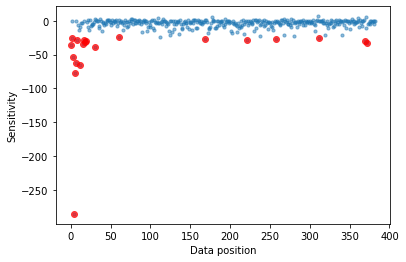

In [ ]:
x = []
Total_simi = sen_numpy
for i in range(len(Total_simi)):
    x.append(i)
y = Total_simi
plt.scatter(x, y,s = 10,alpha = 0.5)

y2 = []
for i in simi:
    y2.append(Total_simi[i])

plt.scatter(simi, y2, c = 'red',alpha = 0.7) 
plt.xlabel('Data position')
plt.ylabel('Sensitivity')
plt.savefig('Sensitivity_final.tif', dpi = 400)
plt.show()